#### Update met_em with current met_em + ( future_climate - Current_climate)
- Calcuate current and future climate (average) 
- Calculate the differences of current and future climate
- Update the met_em files by adding the differences
- Quick check the results

Ming Ge Oct 2024

In [1]:
import glob
import os
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
def cal_avg(dir_d, flnm_0):
    '''
    calculate the average of 5 thermal variables of met_em
    GHT, TT, RH, SST, SKINTEMP
    cal_avg('/met_em_data_dir/', 'met_em.d*.1946-0*.nc')
    '''
    
    flnm_1d = sorted(glob.glob(dir_d + flnm_0))
    n_file = len(flnm_1d)
    #print(dir_d + flnm_0)
    is_first = True
    for nf in range(n_file):
        flnm = flnm_1d[nf]
        with xr.open_dataset(flnm) as ds:
            if is_first == True:
                GHT = ds.GHT.copy(deep=True)
                TT  = ds.TT.copy(deep=True)
                RH  = ds.RH.copy(deep=True)
                SST = ds.SST.copy(deep=True)
                SKINTEMP = ds.SKINTEMP.copy(deep=True)
                is_first = False
            else:
                GHT.values = GHT.values + ds.GHT.values
                TT.values  = TT.values +  ds.TT.values
                RH.values  = RH.values +  ds.RH.values
                SST.values = SST.values + ds.SST.values
                SKINTEMP.values = SKINTEMP.values + ds.SKINTEMP.values

    GHT.values = GHT.values/float(n_file)
    TT.values  = TT.values/float(n_file)
    RH.values  = RH.values/float(n_file)
    SST.values = SST.values/float(n_file)
    SKINTEMP.values = SKINTEMP.values/float(n_file)
    return GHT, TT, RH, SST, SKINTEMP


In [3]:
def update_met_em(dir_old, dir_new, dom_s, GHT_d, TT_d, RH_d, SST_d, SKINTEMP_d):
     
    len_dir = len(dir_old)
    flnm_1d = sorted(glob.glob(dir_old + 'met_em.d' + dom_s + '.*nc'))
    n_file = len(flnm_1d)
    # James has a bad file
    flnm_bad = '/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/met_em.d01.2021-08-24_00:00:00.nc'
    for flnm in flnm_1d:
        if flnm != flnm_bad:
            flnm_o = dir_new + flnm[len_dir:]
    
            with xr.open_dataset(flnm) as ds:
                ds.GHT.values = ds.GHT.values + GHT_d
                ds.TT.values = ds.TT.values + TT_d  
                ds.RH.values = ds.RH.values + RH_d  
                ds.SST.values = ds.SST.values + SST_d  
                ds.SKINTEMP.values = ds.SKINTEMP.values + SKINTEMP_d 
            #print(flnm_o)
            ds.to_netcdf(flnm_o) # rewrite to netcdf    

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def plot_2d(lat, lon, data_2d, color_map, title_s):
    fig = plt.figure(figsize=(10,14))

    # Set the axes using the specified map projection
    ax=plt.axes(projection=ccrs.PlateCarree())
    
    # Make a filled contour plot
    filled_c = ax.contourf(lon, lat, data_2d,
                           #levels =np.arange(3, 5., 0.1), extend='both',
                           cmap = color_map, transform = ccrs.PlateCarree())

    # Add coastlines
    ax.coastlines()
    ax.add_feature(cfeature.STATES, zorder=1, linewidth=.3, edgecolor='black')
    ax.set_title(title_s)
    
    ax = plt.gca()
    ax.gridlines(draw_labels=True)   
    # or..
    #ax.set_xticks([10, 50, 0, 20, 40], crs=ccrs.PlateCarree())

    # Add a colorbar for the filled contour.
    # and pad argument to set colorbar away from x-axis
    fig.colorbar(filled_c,  label= 'mm/hr', pad = 0.05, fraction=0.04, orientation="horizontal"); # 

#### Calcuate current and future climate (average)

In [12]:
%%time

dom_s = '01'

dir_current = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Current/'
dir_future = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_Future/'

var_s_1d = ['GHT', 'TT', 'RH', 'SST', 'SKINTEMP']
GHT,   TT,   RH,   SST,   SKINTEMP   = cal_avg(dir_current, 'met_em.d' + dom_s + '.1956-0*.nc')
GHT_f, TT_f, RH_f, SST_f, SKINTEMP_f = cal_avg(dir_future,  'met_em.d' + dom_s + '.2056-0*.nc')

CPU times: user 5min 54s, sys: 49.5 s, total: 6min 44s
Wall time: 11min 18s


- Calculate the differences of current and future climate

In [13]:
GHT_df = GHT_f - GHT
TT_df  = TT_f - TT
RH_df  = RH_f - RH
SST_df = SST_f - SST
SKINTEMP_df = SKINTEMP_f - SKINTEMP

- Update  simulation

In [14]:
dir_old = '/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/'
dir_new = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_new/'
update_met_em(dir_old, dir_new, dom_s, GHT_df, TT_df, RH_df, SST_df, SKINTEMP_df)

#### Quick check the results

/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_new/met_em.d01.2021-08-26_12:00:00.nc
/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/met_em.d01.2021-08-26_12:00:00.nc
GHT
TT
RH
SST
SKINTEMP


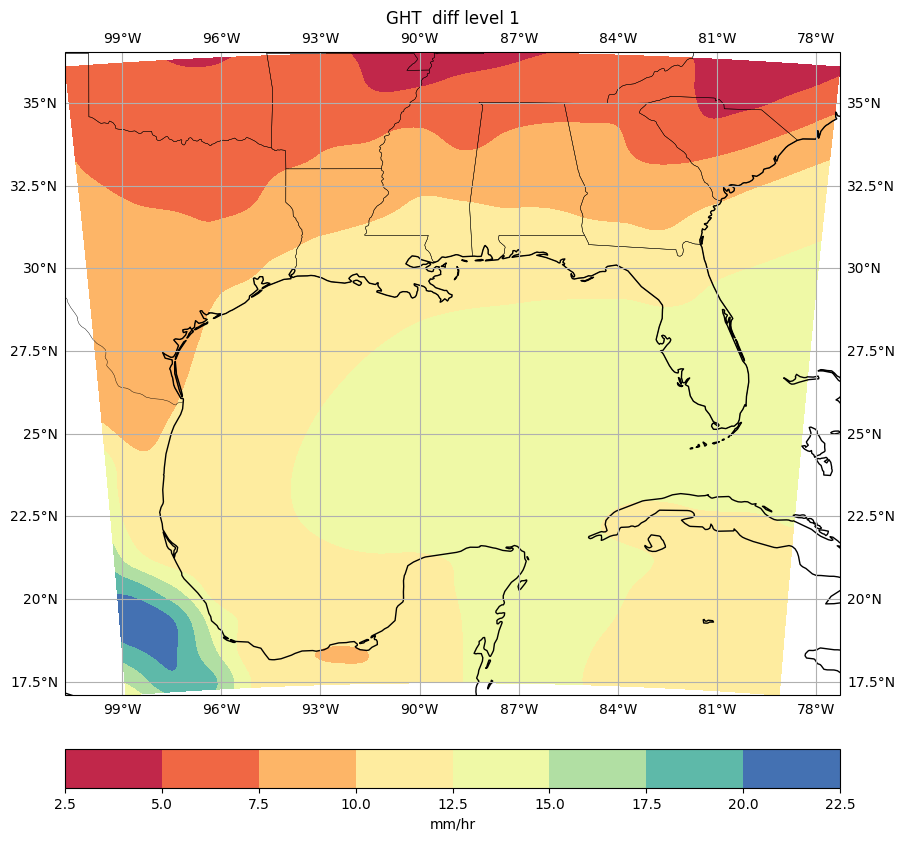

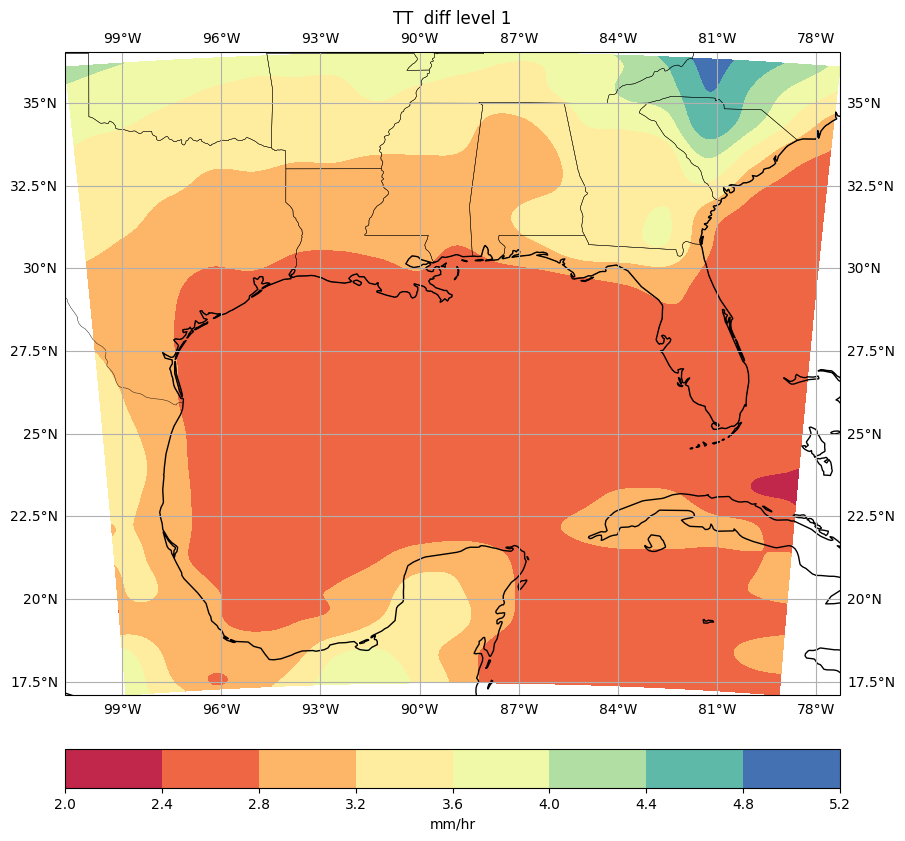

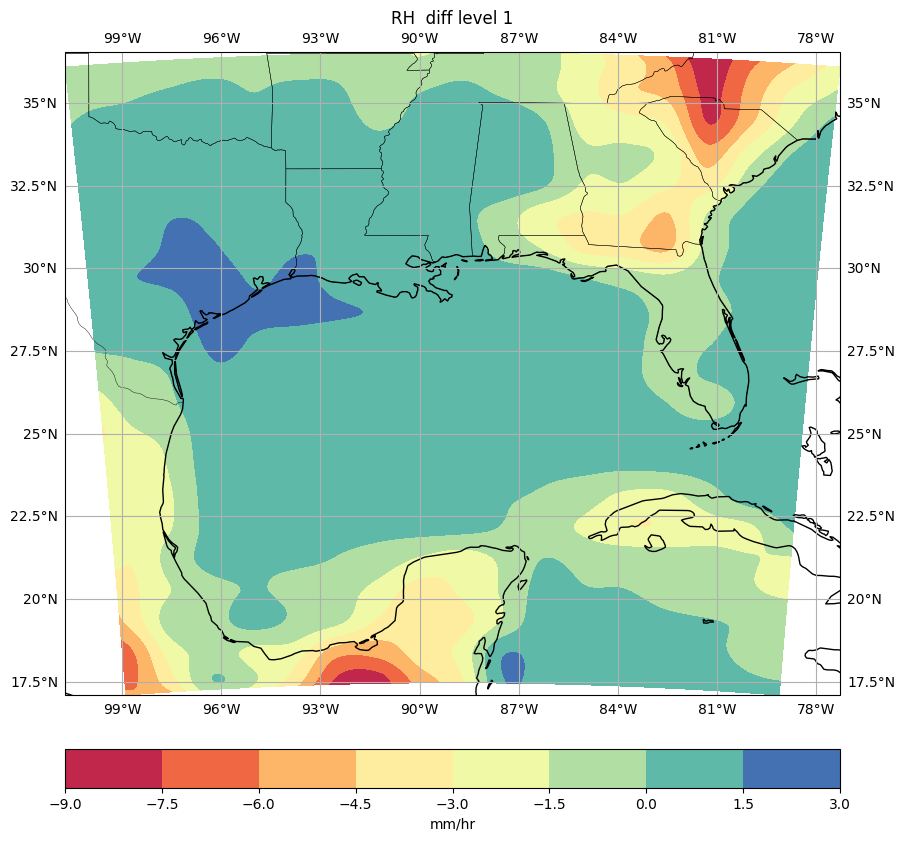

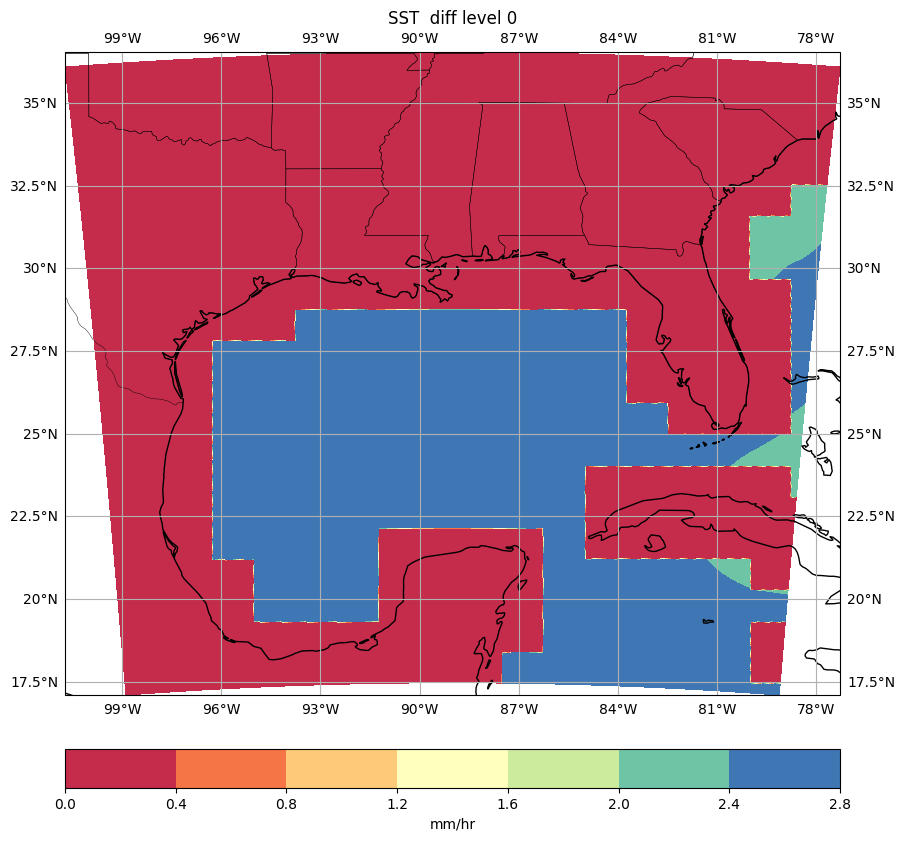

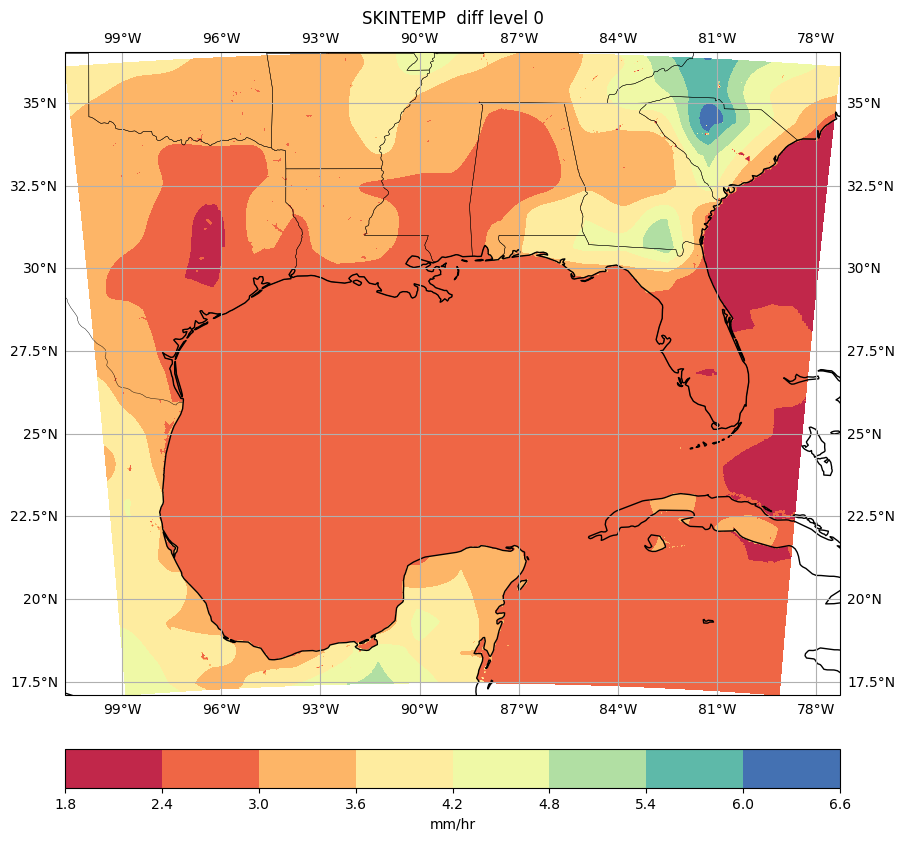

In [16]:
dir_old = '/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/'

dom_s = '01'
flnm = 'met_em.d' + dom_s +'.2021-08-26_12:00:00.nc'
 
flnm_new = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_new/' + flnm
flnm_old = dir_old + flnm

print(flnm_new)
print(flnm_old)

for nv in range(len(var_s_1d)):
    print(var_s_1d[nv])
    with xr.open_dataset(flnm_old) as ds_old:
        TT_old = ds_old[var_s_1d[nv]][0]
    with xr.open_dataset(flnm_new) as ds_new:
        TT_new = ds_new[var_s_1d[nv]][0] 
    if nv == 0:
        lat_2d = ds_old.XLAT_M[0]
        lon_2d = ds_old.XLONG_M[0]

    TT_dif = TT_new-TT_old
    if var_s_1d[nv] == 'SST' or var_s_1d[nv] == 'SKINTEMP':
        plot_2d(lat_2d, lon_2d, TT_dif, 'Spectral', var_s_1d[nv] + '  diff level 0')
    else:
        plot_2d(lat_2d, lon_2d, TT_dif[1], 'Spectral', var_s_1d[nv] + '  diff level 1')

/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_new/met_em.d02.2021-08-26_12:00:00.nc
/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/met_em.d02.2021-08-26_12:00:00.nc
GHT
TT
RH
SST
SKINTEMP


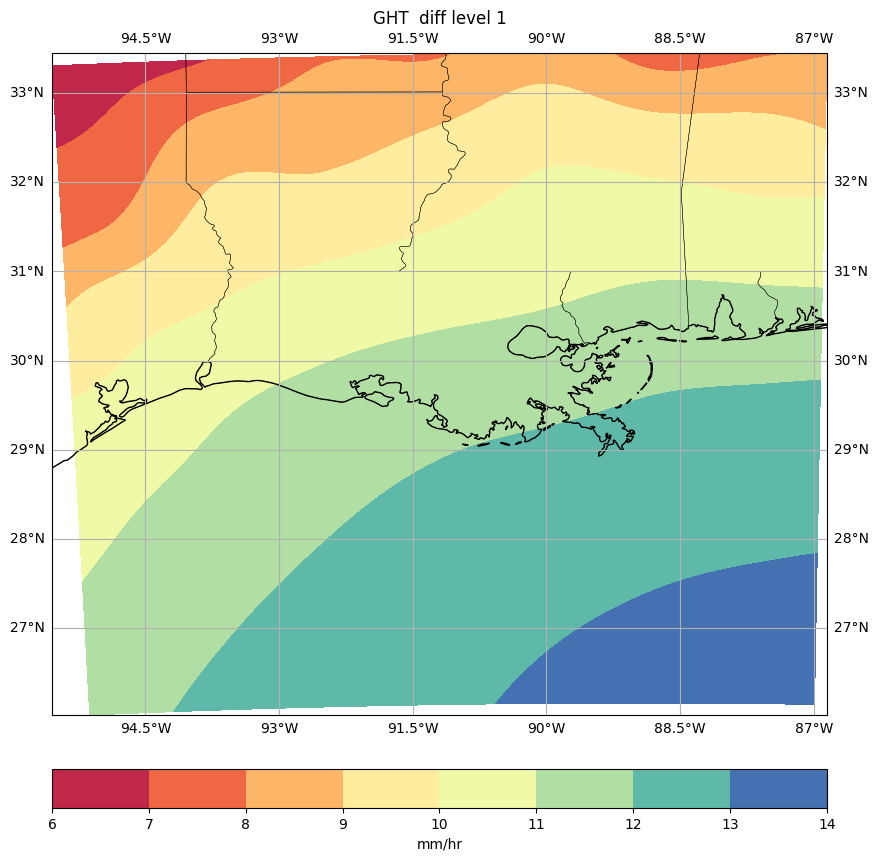

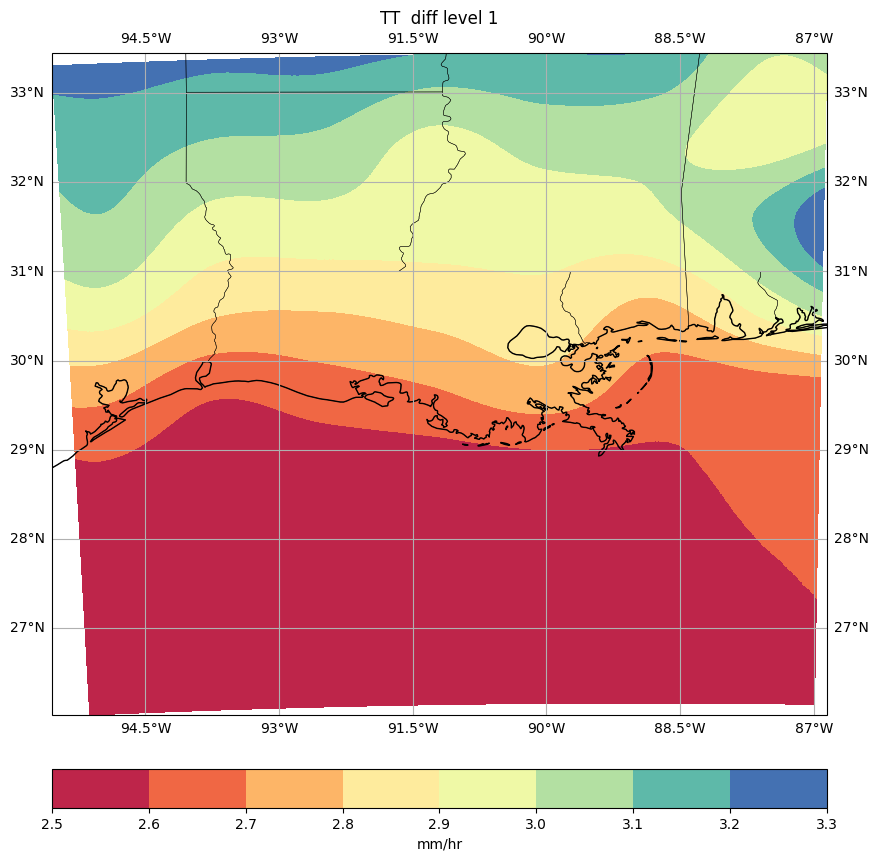

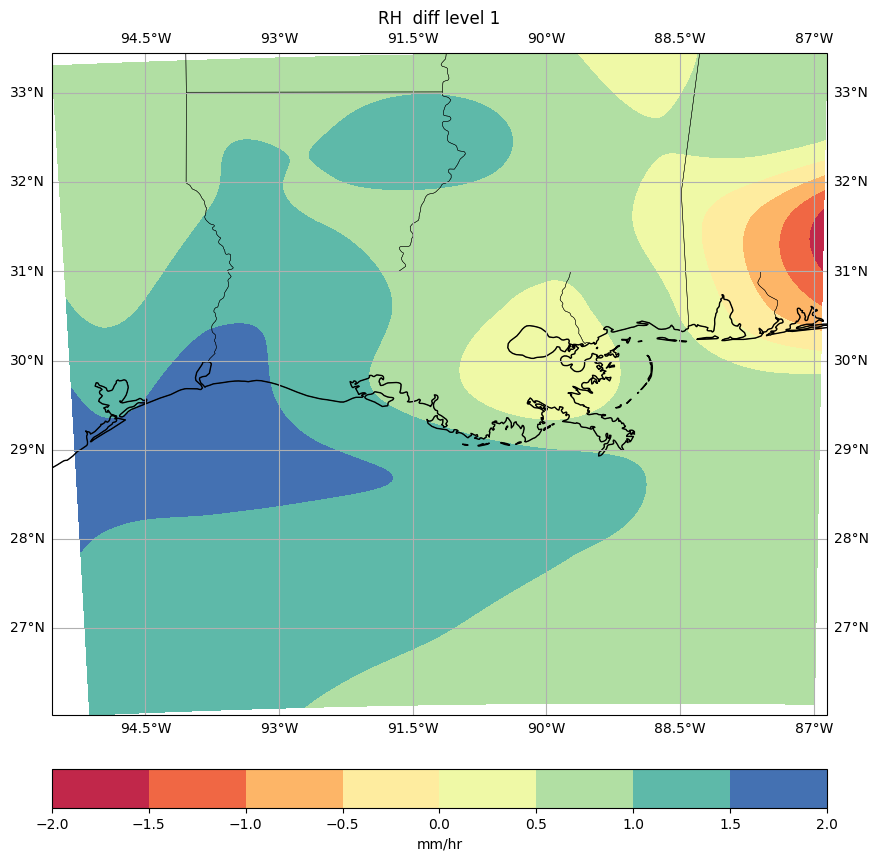

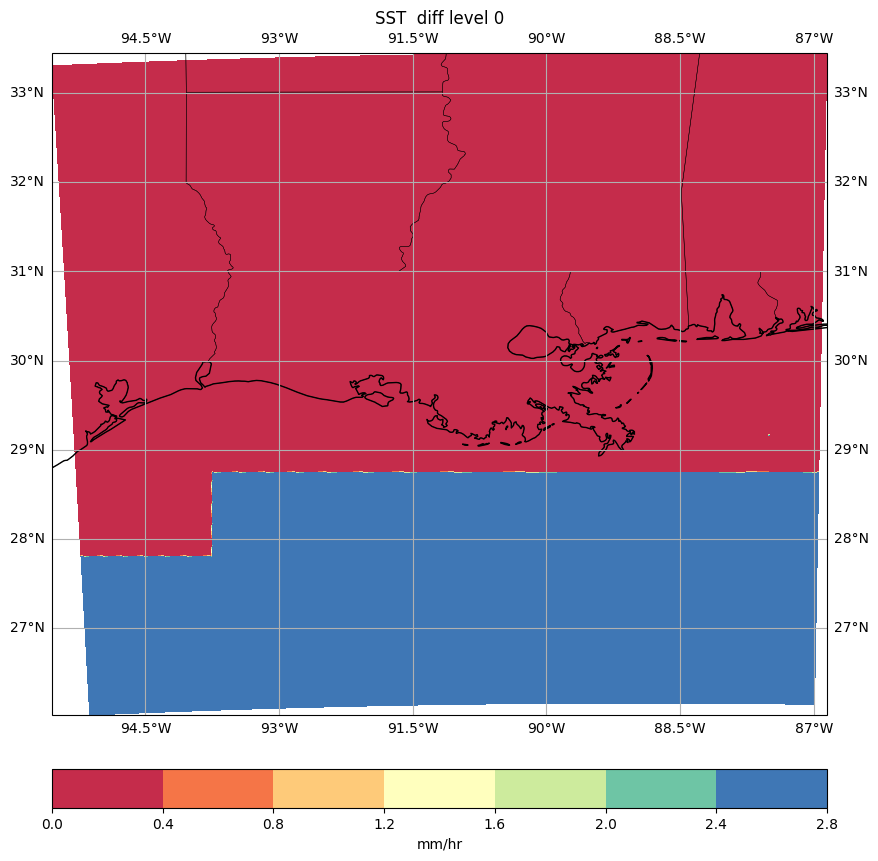

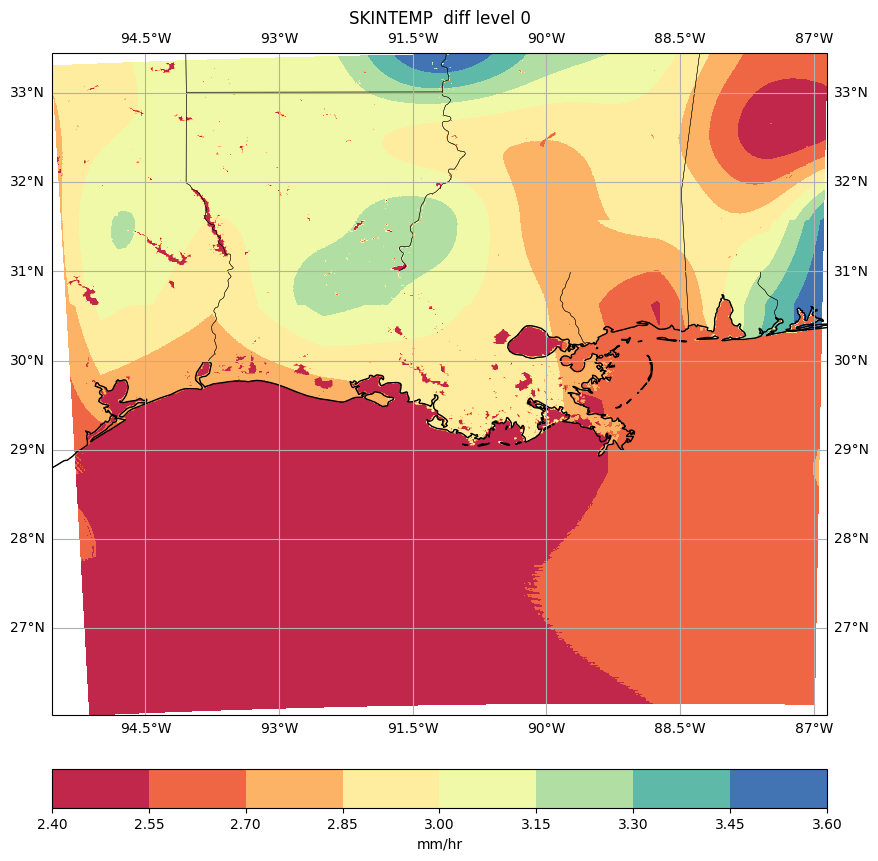

In [17]:
dir_old = '/glade/campaign/mmm/c3we/done/smiley/wpsv4.5/'
 
flnm = 'met_em.d02.2021-08-26_12:00:00.nc'
 
flnm_new = '/glade/derecho/scratch/mingge/wpsv4.5_ida/IDA_James_new/' + flnm
flnm_old = dir_old + flnm

print(flnm_new)
print(flnm_old)

for nv in range(len(var_s_1d)):
    print(var_s_1d[nv])
    with xr.open_dataset(flnm_old) as ds_old:
        TT_old = ds_old[var_s_1d[nv]][0]
    with xr.open_dataset(flnm_new) as ds_new:
        TT_new = ds_new[var_s_1d[nv]][0] 
    if nv == 0:
        lat_2d = ds_old.XLAT_M[0]
        lon_2d = ds_old.XLONG_M[0]

    TT_dif = TT_new-TT_old
    if var_s_1d[nv] == 'SST' or var_s_1d[nv] == 'SKINTEMP':
        plot_2d(lat_2d, lon_2d, TT_dif, 'Spectral', var_s_1d[nv] + '  diff level 0')
    else:
        plot_2d(lat_2d, lon_2d, TT_dif[1], 'Spectral', var_s_1d[nv] + '  diff level 1')